<a href="https://colab.research.google.com/github/MosesDynasty/FXpredict/blob/main/EMFtrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import sklearn.model_selection

In [4]:

# Setting the seed for reproducibility
np.random.seed(42)

# Generate a date range
date_range = pd.date_range(start='2020-01-01', end='2022-01-01', freq='B')  # 'B' for business days

# Generate synthetic forex data
data = {
    'Date': date_range,
    'Open': np.random.rand(len(date_range)) * 100,
    'High': np.random.rand(len(date_range)) * 100,
    'Low': np.random.rand(len(date_range)) * 100,
    'Close': np.random.rand(len(date_range)) * 100,
    'Volume': np.random.randint(1000, 10000, size=len(date_range))
}

# Create a DataFrame
df = pd.DataFrame(data)

# Ensure High is always greater than Low
df['High'] = df[['Open', 'High', 'Low']].max(axis=1)
df['Low'] = df[['Open', 'High', 'Low']].min(axis=1)
df['Close'] = np.random.uniform(df['Low'], df['High'])

# Sort by Date
df = df.sort_values(by='Date')

# Save to CSV
df.to_csv('data/synthetic_forex_data.csv', index=False)

# Display the first few rows of the dataset
df.head()


,Date,Open,High,Low,Close,Volume
0,2020-01-01,37.454012,84.211892,23.295947,38.051691,3551
1,2020-01-02,95.071431,95.071431,2.440078,46.741938,7411
2,2020-01-03,73.199394,87.009887,73.199394,75.204630,1007
3,2020-01-06,59.865848,59.865848,2.126941,43.127920,9087
4,2020-01-07,15.601864,87.470167,15.601864,63.527560,3555


In [17]:
# Load the synthetic forex dataset
df = pd.read_csv('data/synthetic_forex_data.csv')

# Check for missing values
missing_values = df.isnull().sum()

# Display the first few rows and missing values information
df.head(), missing_values


(         Date       Open       High        Low      Close  Volume
 0  2020-01-01  37.454012  84.211892  23.295947  38.051691    3551
 1  2020-01-02  95.071431  95.071431   2.440078  46.741938    7411
 2  2020-01-03  73.199394  87.009887  73.199394  75.204630    1007
 3  2020-01-06  59.865848  59.865848   2.126941  43.127920    9087
 4  2020-01-07  15.601864  87.470167  15.601864  63.527560    3555,
 Date      0
 Open      0
 High      0
 Low       0
 Close     0
 Volume    0
 dtype: int64)

In [18]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by 'Date'
df = df.sort_values(by='Date')

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Calculate Simple Moving Averages (SMA)
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()

# Calculate Exponential Moving Averages (EMA)
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
def compute_RSI(data, window):
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = compute_RSI(df['Close'], 14)

# Create lagged features
df['Lag_1_Close'] = df['Close'].shift(1)
df['Lag_1_High'] = df['High'].shift(1)
df['Lag_1_Low'] = df['Low'].shift(1)
df['Lag_1_Volume'] = df['Volume'].shift(1)

# Drop rows with NaN values created by rolling and lagged features
df = df.dropna()

# Display the first few rows with new features
df


,Open,High,Low,Close,Volume,SMA_5,SMA_10,EMA_5,EMA_10,RSI_14,Lag_1_Close,Lag_1_High,Lag_1_Low,Lag_1_Volume
Date,,,,,,,,,,,,,,
2020-01-14,70.807258,99.663684,35.071182,44.910531,7710,60.921987,57.126367,59.901153,56.861335,51.514316,71.771231,99.971767,60.111501,8239.0
2020-01-15,2.058449,76.718829,2.058449,21.930654,6000,60.613570,55.514264,47.244320,50.510302,46.768637,44.910531,99.663684,35.071182,7710.0
2020-01-16,96.990985,96.990985,40.193091,41.444174,5654,52.527886,54.984487,45.310938,48.861915,50.630667,21.930654,76.718829,2.058449,6000.0
2020-01-17,83.244264,94.476573,47.987562,75.102626,9078,51.031843,54.974287,55.241501,53.632953,56.121726,41.444174,96.990985,40.193091,5654.0
2020-01-20,21.233911,84.964739,21.233911,74.909974,7063,51.659592,58.152492,61.797658,57.501503,56.086021,75.102626,94.476573,47.987562,9078.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,98.727613,98.727613,82.261432,92.342985,9549,39.443986,52.068302,59.096863,55.736502,51.190745,51.540197,81.055333,27.480604,6242.0
2021-12-28,15.041689,42.373825,15.041689,20.865758,6647,42.685330,49.719367,46.353161,49.396366,47.163287,92.342985,98.727613,82.261432,9549.0
2021-12-29,59.413072,66.754990,59.413072,66.307552,6185,54.686605,50.223953,53.004625,52.471127,47.352851,20.865758,42.373825,15.041689,6647.0


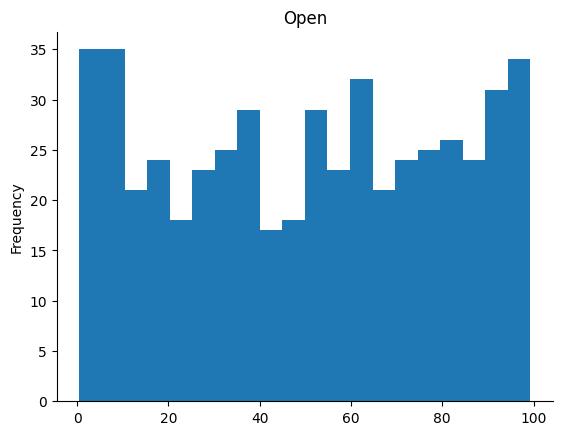

In [21]:
# @title Open

from matplotlib import pyplot as plt
df['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [19]:
from sklearn.model_selection import train_test_split

# Define the features and target
features = df.drop(columns=['Close'])
target = df['Close']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

# Display the shapes of the training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((411, 13), (103, 13), (411,), (103,))

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 30.46670989410502
